# Clasificación del Tipo de Reparación a partir de los Repuestos Solicitados

Este notebook simula pedidos de repuestos automotrices y clasifica el tipo de reparación (frenos, motor, suspensión o eléctrico) según los ítems solicitados.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [13]:
np.random.seed(42)

In [14]:
# 1. Crear dataset simulado de pedidos de repuestos
n_samples = 1000

df = pd.DataFrame({
    'brake_parts': np.random.poisson(lam=1, size=n_samples),
    'engine_parts': np.random.poisson(lam=1.5, size=n_samples),
    'suspension_parts': np.random.poisson(lam=1, size=n_samples),
    'electrical_parts': np.random.poisson(lam=0.8, size=n_samples),
})

# Definir etiqueta: tipo de reparación
def assign_repair_type(row):
    max_idx = np.argmax([
        row['brake_parts'],
        row['engine_parts'],
        row['suspension_parts'],
        row['electrical_parts']
    ])
    return max_idx

df['repair_type'] = df.apply(assign_repair_type, axis=1)

df.head()


,brake_parts,engine_parts,suspension_parts,electrical_parts,repair_type
0,1,2,0,0,1
1,2,2,4,0,2
2,0,2,0,2,1
3,0,0,1,1,2
4,3,0,1,1,0


In [15]:
df['repair_type'].value_counts()

repair_type
1    412
0    352
2    159
3     77
Name: count, dtype: int64

In [16]:
# 2. Dividir en entrenamiento y prueba
X = df.drop(columns='repair_type')
y = df['repair_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



In [17]:
# 3. Balancear solo el conjunto de entrenamiento
train_df = X_train.copy()
train_df['repair_type'] = y_train

balanced_train_df = pd.concat([
    resample(train_df[train_df.repair_type == i], 
             replace=True, 
             n_samples=train_df['repair_type'].value_counts().max(), 
             random_state=42)
    for i in train_df['repair_type'].unique()
])

X_train_bal = balanced_train_df.drop(columns='repair_type')
y_train_bal = balanced_train_df['repair_type']

In [18]:
balanced_train_df['repair_type'].value_counts()

repair_type
0    289
3    289
1    289
2    289
Name: count, dtype: int64

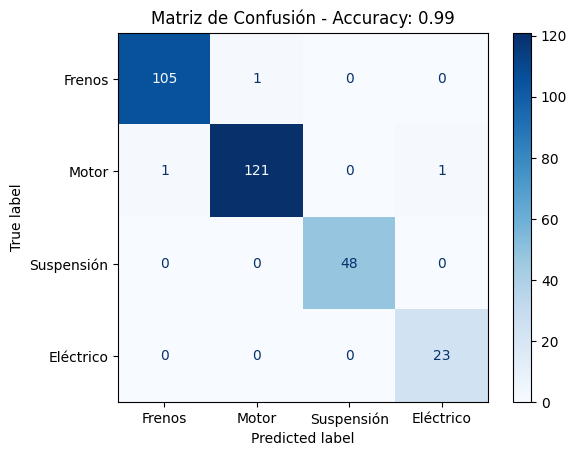

In [19]:
# 4. Entrenar el modelo
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_bal, y_train_bal)

# 5. Evaluar en test original
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

# 6. Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Frenos", "Motor", "Suspensión", "Eléctrico"])
disp.plot(cmap="Blues")
plt.title(f"Matriz de Confusión - Accuracy: {acc:.2f}")
plt.show()
